In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import os

## objective :

In this notebook, we evaluate our ability to rotate an object

## defining the lat/lon grid :

In [676]:
n = 400
m,n = 2*n, n # number longitudes, number of latitudes 
phi,theta = np.linspace(-np.pi,np.pi,m), np.linspace(-np.pi/2,np.pi/2,n)
THETA, PHI = np.meshgrid(range(n),range(m))
deg_to_radian = 2*np.pi/360

theta, phi = np.meshgrid(theta, phi)
dtheta = np.abs(theta[0,0]-theta[0,1])
dphi = np.abs(phi[0,0]-phi[1,0])

R = 1

ex,ey,ez = np.eye(3)


e_r = np.array([np.cos(theta)*np.cos(phi),
               np.cos(theta)*np.sin(phi),
               np.sin(theta)]).T * R

e_theta = np.array([-np.sin(theta)*np.cos(phi),
               -np.sin(theta)*np.sin(phi),
               np.cos(theta)]).T * R

e_phi = np.array([-np.cos(theta)*np.sin(phi),
                 np.cos(phi)*np.cos(theta),
                 np.cos(theta)*0]).T * R


X = R * np.cos(theta)*np.cos(phi)
Y = R * np.cos(theta)*np.sin(phi)
Z = R * np.sin(theta)

OM = X[:,:,np.newaxis]*ex + Y[:,:,np.newaxis]*ey + Z[:,:,np.newaxis]*ez

def projection(vecteur):
    return (np.dot(vecteur,ex),np.dot(vecteur,ey),np.dot(vecteur,ez))

## initial concentration :

  7%|█████▎                                                                        | 11/161 [33:33<7:37:35, 183.04s/it]


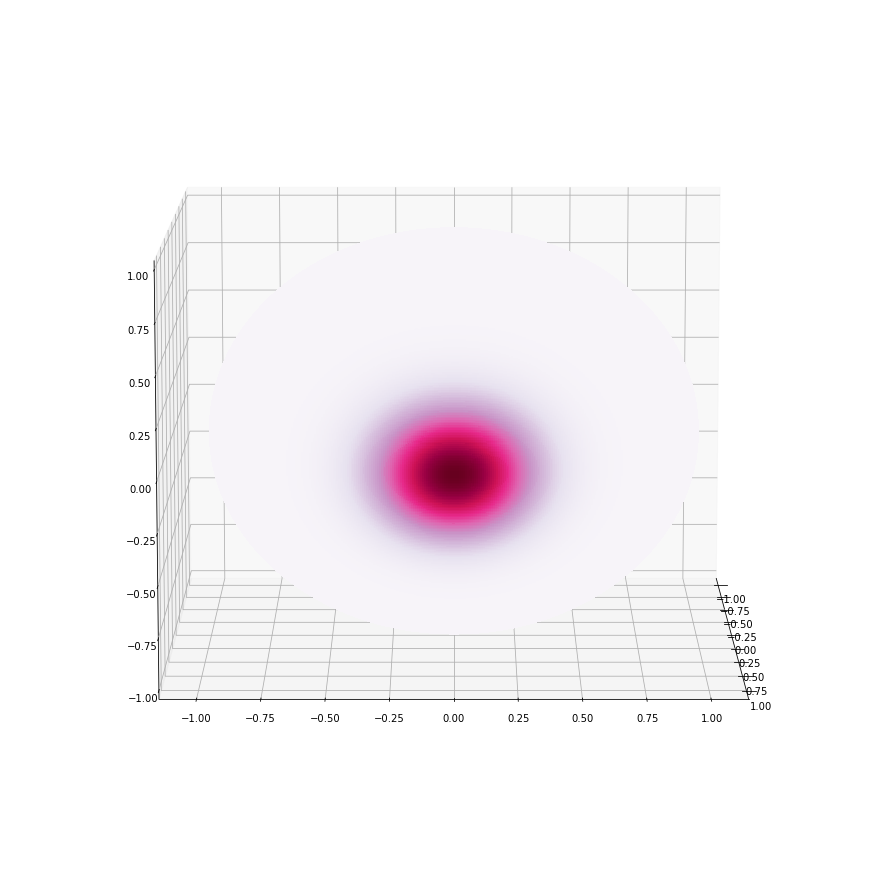

In [677]:
x,y,z = 1,0,0
lh = 0.3


distX = X-x
distY = Y-y
distZ = Z-z
dist = np.linalg.norm(np.array([distX,distY,distZ]),ord=2,axis=0)  

X0 = np.exp(- dist **2 / lh**2)

from matplotlib import colors, cm
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=10., azim=0)

strength = X0
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.PuRd,
                       linewidth=0, antialiased=False,
                       facecolors=cm.PuRd(norm(strength)),zorder=1)

## the wind field for rotation along the $z$-axis:



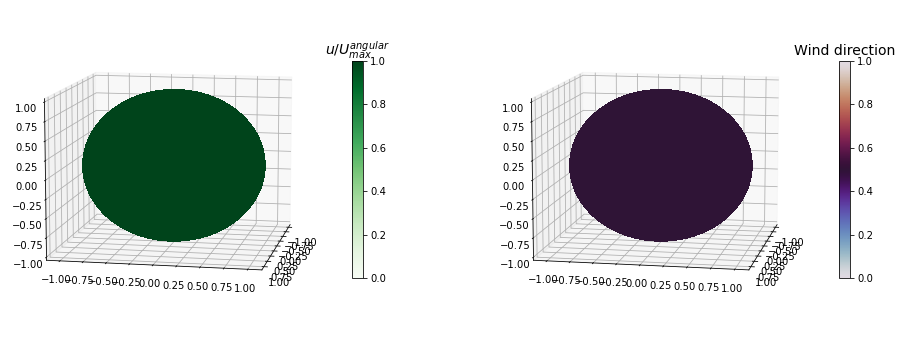

In [678]:
wind_1 = random_field()*0  #theta : parallel to the longitude : going down/up
wind_2 = random_field()*0 + 1  #1#np.cos(theta)  #phi : parallel to the latitude : going sideways


# wind_theta = (wind_1.T[np.newaxis].T) * e_theta
# wind_phi = (wind_2.T[np.newaxis].T) * e_phi#_norm

wind = np.array([wind_1, wind_2]) #theta, phi
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(1,2,1,projection='3d')
length = .025
ax.view_init(elev=10., azim=11)

ds = 4

strength = np.linalg.norm(np.array([wind_1, wind_2]),axis=0)
norm=colors.Normalize(vmin = 0, vmax = strength.max(), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.Greens,
                       linewidth=0, antialiased=False,
                       facecolors=cm.Greens(norm(strength)),zorder=-1)

cb = fig.colorbar(surface,ax=ax,shrink=0.25)
cb.ax.set_title(r"$u/U^{angular}_{max}$",fontsize=14)

ax2 = fig.add_subplot(1,2,2,projection='3d')
length = .025
ax2.view_init(elev=10., azim=11)


strength = np.arctan2(*wind)
norm=colors.Normalize(vmin = -np.pi, vmax = np.pi, clip = False)

surface = ax2.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.twilight,
                       linewidth=0, antialiased=False,
                       facecolors=cm.twilight(norm(strength)),zorder=-1,vmin=-np.pi,vmax=np.pi)

cb = fig.colorbar(surface,ax=ax2,shrink=0.25)
cb.ax.set_title("Wind direction",fontsize=14)
plt.show()

### normalizing the wind field :

In [679]:
wind = wind/np.linalg.norm(wind,axis=0).max()
max_wind_speed = 50 #kmh
D = 6370 #earth radius in km
wind = wind/D * max_wind_speed

In [680]:
def BilinearSpherical(thetad, phid, state):
    # do bilinear interpolation on "rectangles" defined by the lat/lon grid.
    THETAd = THETA + (thetad-theta)/dtheta
    PHId = PHI + (phid-phi)/dphi + (phid*phi < 0 )*1.0
    state = state.T
    interpolation = (1-THETAd%1)*(  (1-PHId%1) * state[THETAd.astype(int)       ,  PHId.astype(int)      ]
                                           + (PHId % 1) * state[THETAd.astype(int)       ,  (PHId+1).astype(int)%n] ) \
            +  (THETAd % 1) *(  (1-PHId%1) * state[(THETAd+1).astype(int)%n ,  PHId.astype(int)      ]
                                           + (PHId % 1) * state[(THETAd+1).astype(int)%n ,  (PHId+1).astype(int)%n] )
    
    return interpolation

In [681]:
def SphericalPeriodisation(thetad, phid):
    # apply the following corrections : (theta, +-pi +- espsilon) = (theta, -+pi +-epsilon)
    #                                   (pi/2 + espilon, phi) = (pi/2 - epsilon, phi + pi)
    # etc.
    
    indices = np.where(thetad>np.pi/2)
    epsilon = thetad[indices] - np.pi/2
    thetad[indices] = np.pi/2 - epsilon
    phid[indices] = phid[indices] + np.pi

    
    indices = np.where(thetad <-np.pi/2)
    epsilon = thetad[indices] + np.pi/2
    thetad[indices] = np.pi/2 + epsilon
    phid[indices] = phid[indices] + np.pi
    
    indices = np.where( phid>np.pi)
    phid[indices] -= 2*np.pi
    indices = np.where(phid<-np.pi)
    phid[indices] += 2*np.pi
    
    return thetad, phid

In [682]:
from mypackage.problem import Model

class SemiLagShericalAdv(Model):
    def _make_trend(self):
        wind_phi = self.trend_parameters[0]
        thetad = theta - self.dt*wind[0]
        phid = phi - self.dt*wind[1]
        self.thetad, self.phid = SphericalPeriodisation(thetad,phid)
        
    def _step(self, new_dt=None):
        self.x = BilinearSpherical(self.thetad, self.phid, self.x)
        #saving :
        self.t += self.dt
        if self.save and (self.time_saving_interval =="all"  or self.t - self.last_saved_time >= self.time_saving_interval) :
            self.saved_times.append(self.t)
            self.trajectory[self.t] = self.x
            self.last_saved_time = self.t

## Numerical experiment :

In [732]:
t_end = 2*np.pi*D / max_wind_speed # time for one revolution.
dt = .25  #time step in hour

SL = SemiLagShericalAdv(X0, dt=dt, trend_parameters=[wind],time_saving_interval=40)
SL.forecast(t_end)

100%|██████████████████████████████████████████████████████████████████████████████| 3202/3202 [05:13<00:00, 10.21it/s]


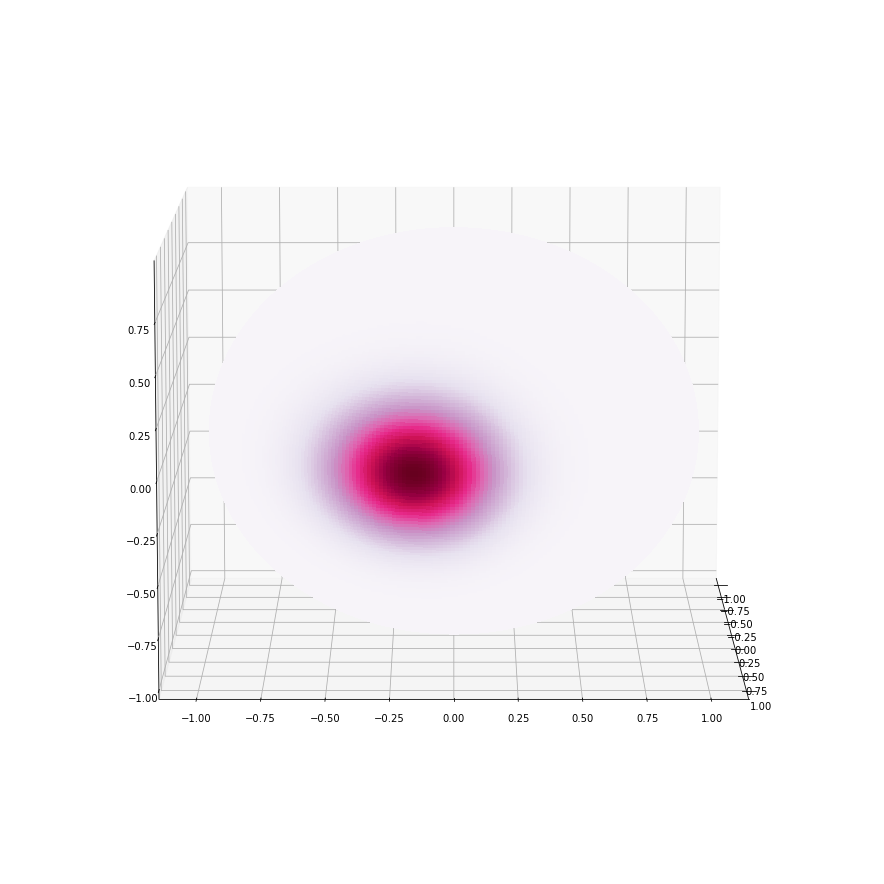

In [733]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=10., azim=0)

ds = 2
strength = SL.x[::ds,::ds]
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM[::ds,::ds]), rstride=1, cstride=1,cmap = cm.PuRd,
                       linewidth=0, antialiased=False,
                       facecolors=cm.PuRd(norm(strength)),zorder=1)

We observe some diffusion along the latitude lines : this is due to the bilinear interpolation method. This could be improved by using a higher order interpolation method such as Bicubic Spline interpolation. This is what we try to do hereafter.

## Mass variation during experiment :

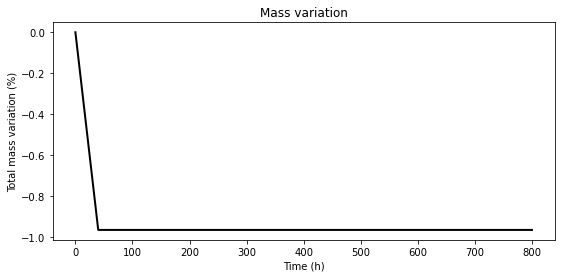

In [734]:
traj = np.array(list(SL.trajectory.values()))
mass = traj.sum(axis=(1,2))
mass_variation = (mass/mass[0] - 1)*100
plt.figure(figsize=(9,4))
plt.plot(SL.saved_times,mass_variation,c='k',linewidth = 2 )
plt.title("Mass variation");
plt.ylabel("Total mass variation (%)")
plt.xlabel("Time (h)");

this indicates a boundary treatment problem around $\phi = 0$. To be solved.

## saving successive iterations to make a GIF : 

In [608]:
def index_img(index):
    if index < 10 :
        return '00'+str(index) 
    elif 10<= index < 100 :
        return '0'+str(index) 
    else:
        return index

In [106]:
from tqdm import tqdm
path = '../../../Pictures/sphere_plot/'
angles = np.arctan2(wind_2,wind_1)
from sklearn.preprocessing import MinMaxScaler
# angles = MinMaxScaler().fit_transform(angles)
# angles[indices]
ds = 2
for i,(time, x) in tqdm(enumerate(zip(SL.saved_times,SL.trajectory.values()))):
    indices = np.where(X0[::ds,ds::]>0.01)
    
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(1,1,1,projection='3d')
    length = .005
    ax.view_init(elev=10., azim=11)

    strength = x
    norm=colors.Normalize(vmin = 0, vmax = 1, clip = False)

    surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,cmap = cm.Greens,
                           linewidth=0, antialiased=False,
                           facecolors=cm.Greens(norm(strength)),zorder=-1,vmin=0,vmax=strength.max())
#     ax.quiver(*projection(OM[indices]), *projection((wind_phi+wind_theta)[indices]),
#               length=length, normalize=False,color='k',zorder=3,linewidth=0.5);
#     ax.quiver(*projection(OM[::ds,ds::][indices]), *projection((wind_phi+wind_theta)[::ds,ds::][indices]),
#               length=length, normalize=False,colors='k',zorder=3,linewidth=0.5);
    cb = fig.colorbar(surface,ax=ax,shrink=0.25)
    fig.savefig(path+str(index_img(i)))
    fig.clear()
    
    img = plt.imread(path+str(index_img(i))+".png")
    img= img[650:1100,490:1050]
    plt.imsave(path+str(index_img(i))+'.png',img)

KeyboardInterrupt: 

In [999]:
import glob
from PIL import Image

fp_in = path +'*.png'
fp_out = 'animated_plots/'+'sphere_plot'+'lol.gif'

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=100, loop=0)


making the GIF file...


## Bicubic spline test (doesnt work)

https://fr.wikipedia.org/wiki/Interpolation_bicubique

In [103]:
from mypackage.domain import *
domain2d = Domain2D(n,n)

In [253]:
A = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0],
              [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
              [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
              
              [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,2,0,0,0,3,0,0,0],
              [0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3],
              
              [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0],
              [0,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3],
              
              [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,2,0,0,0,3,0,0],
              [0,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,2,3,0,2,4,6,0,3,6,9]])

invA = np.linalg.inv(A)

In [424]:
dt = 0.5
SL = SemiLagShericalAdv(X0, dt=dt, trend_parameters=[wind],time_saving_interval=40)

#### one step using bicubic interpolation :

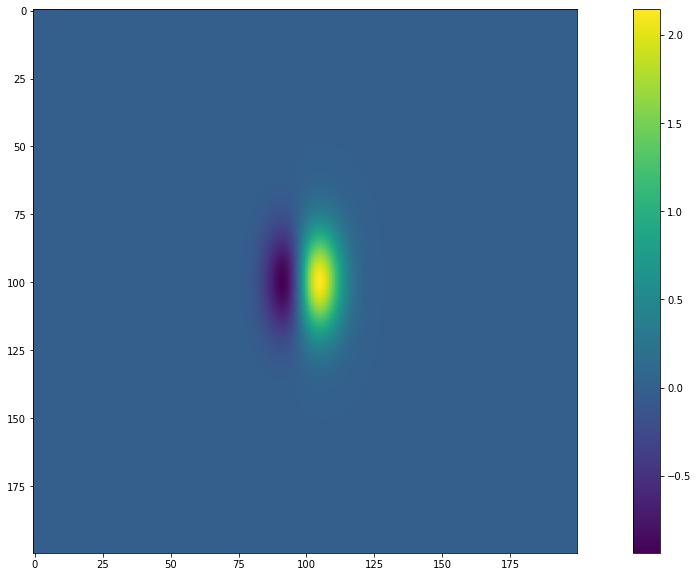

In [602]:
thetad = SL.thetad 
phid = SL.phid


PHI_ = (PHI+1).astype(int)%n
THETA_ = (THETA+1).astype(int)%n

THETAd = THETA + (thetad-theta)/dtheta
PHId = PHI + (phid-phi)/dphi + (phid*phi < 0 )*1.0

intTHETAd = THETAd.astype(int)
intPHId = PHId.astype(int)

PHId_ = (PHId+1).astype(int)%n
THETAd_ = (THETAd+1).astype(int)%n

state = X0
state_dtheta = domain2d.derive(state,axis=1)
state_dphi   = domain2d.derive(state,axis=0)
state_dphi_dtheta   = domain2d.derive(domain2d.derive(state,axis=1),axis=0)

f00 = state[intPHId, intTHETAd]
f10 = state[intPHId, THETAd_  ]
f01 = state[PHId_, intTHETAd]
f11 = state[PHId_, THETAd_  ]

f00_dtheta = state_dtheta[intPHId, intTHETAd]
f10_dtheta = state_dtheta[intPHId, THETAd_  ]
f01_dtheta = state_dtheta[PHId_, intTHETAd]
f11_dtheta = state_dtheta[PHId_, THETAd_  ]

f00_dphi = state_dphi[intPHId, intTHETAd]
f10_dphi = state_dphi[intPHId, THETAd_  ]
f01_dphi = state_dphi[PHId_, intTHETAd]
f11_dphi = state_dphi[PHId_, THETAd_  ]

f00_dphi_dtheta = state_dphi_dtheta[intPHId, intTHETAd]
f10_dphi_dtheta = state_dphi_dtheta[intPHId, THETAd_  ]
f01_dphi_dtheta = state_dphi_dtheta[PHId_, intTHETAd]
f11_dphi_dtheta = state_dphi_dtheta[PHId_, THETAd_  ]


f_values = np.array([f00,             f10,             f01,             f11,
                     f00_dtheta,      f10_dtheta,      f01_dtheta,      f11_dtheta,
                     f00_dphi,        f10_dphi,        f01_dphi,        f11_dphi,
                     f00_dphi_dtheta, f10_dphi_dtheta, f01_dphi_dtheta, f11_dphi_dtheta])

x = THETAd  % 1
y = PHId % 1

invA = np.linalg.inv(A)

coeffs = np.dot(f_values.T,invA.T).T
coeffs = coeffs.reshape((4,4,n,n))

interpol = np.zeros_like(state)
for i in range(4):
    for j in range(4):
        interpol += coeffs[i,j] * x**i * y**j
        
plt.figure(figsize=((20,10)))
plt.imshow(interpol.T)
plt.colorbar();

<ipython-input-603-0bedb3ff66c1>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-603-0bedb3ff66c1>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-603-0bedb3ff66c1>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-603-0bedb3ff66c1>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


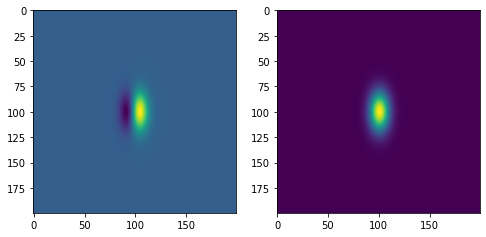

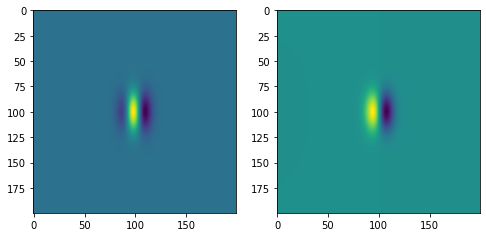

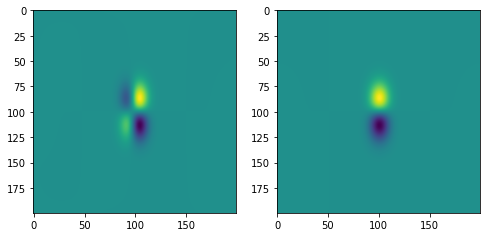

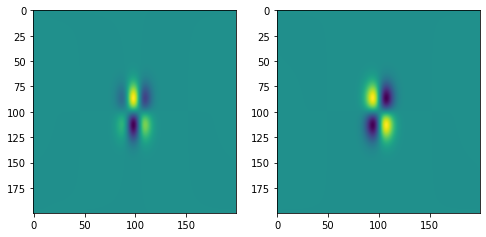

In [603]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(interpol.T)
ax[1].imshow(f00.T)
fig.show()

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(domain2d.derive(interpol,axis=0).T)
ax[1].imshow(f00_dphi.T)
fig.show()

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(domain2d.derive(interpol,axis=1).T)
ax[1].imshow(f00_dtheta.T)
fig.show()

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(domain2d.derive(domain2d.derive(interpol,axis=0),axis=1).T)
ax[1].imshow(f00_dphi_dtheta.T)
fig.show()